# A/B Test for E-Commerce

A/B tests are commonly used in industry to test changes on a web page by exposing a control group to the old webpage and a treatment group to the new web page. The level of user engagement can be measured by a selected metric, in this case we use conversion rate.

## Introduction
An e-commerce company has developed a new web page in order to try and increase purchases (conversions) made through their site. They have run an AB experiment and collected data regarding the number of conversions for a control group and a treatment group. The objective of this project is to assess the data and help the company understand if they should implement this new page, keep the old page, or run the experiment longer to make their decision.

We will then implement logistic regression algorithms in order to predict the probability of a individual users purchasing products from their site.

## Data Overview
The datasets for this project are provided by **Udacity** in association with their **Data Analyst Nanodegree** programme. They have been generated to represent example A/B experiment results from an e-commerce website. There are 2 raw csv files:

  * `ab_test.csv` - contains information regarding the group (control or treatment), landing page (old or new), timestamp of visit and conversion.
  * `countries.csv` - contains information regarding the country of origin of each user.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import os
import sys

%matplotlib inline

path = os.path.abspath(os.path.join('../features'))
if path not in sys.path:
    sys.path.append(path)

import visualise as vis
import model as mod

# Seed random to keep values common for each execution
np.random.seed(42)

In [3]:
df_ab = pd.read_csv('../data/ab_data.csv')
df_country = pd.read_csv('../data/countries.csv')

## Data Assessment

In [4]:
df_ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


* No null values in any column
* Timestamp is object not datetime

In [6]:
df_ab.user_id.duplicated().sum(), df_ab.duplicated().sum()

(3894, 0)

* There are 3894 duplicate `user_id`'s who have visited more than once.
* None of the rows are duplicated

In [7]:
df_ab[df_ab.user_id.duplicated(keep=False)].sort_values(by='user_id').head(10)

,user_id,timestamp,group,landing_page,converted
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0
11792,630137,2017-01-22 14:59:22.051308,control,new_page,0
207211,630320,2017-01-07 18:02:43.626318,control,old_page,0
255753,630320,2017-01-12 05:27:37.181803,treatment,old_page,0
96929,630471,2017-01-07 02:14:17.405726,control,new_page,0
110634,630471,2017-01-23 01:42:51.501851,control,old_page,0


In [8]:
print("Rows misaligned:", (((df_ab.group == "control")&(df_ab.landing_page != "old_page"))|\
        ((df_ab.group == "treatment")&(df_ab.landing_page != "new_page"))).sum())

Rows misaligned: 3893


* There are 3893 rows with mismatched `group` and `landing_page` variables where:
    * `control != old_page` OR `treatment != new_page`

In [9]:
df = df_ab[(((df_ab.group == "control")&(df_ab.landing_page == "old_page"))|\
        ((df_ab.group == "treatment")&(df_ab.landing_page == "new_page")))]

df[df.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


* There is only one duplicated `user_id` in the sample whcih does not have mismatched `group` and `landing_page`. * They were exposed to the new page twice and converted neither times.

In [10]:
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


* `df_country` contains the `user_id` and `country` information. 
* `user_id` is a primary key we can merge the dataframes on

In [11]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [12]:
df_ab.user_id.nunique(), df_country.user_id.nunique()

(290584, 290584)

* There number of unique `user_id`'s in each dataframe are equal.
* There are no duplicated `user_id`'s in `df_country`

### Assessment Summary
* No null values in any column
* Timestamp is object not datetime
* There are 3894 duplicate `user_id`'s who have visited more than once.
* None of the rows are duplicated
* There are 3893 rows with mismatched `group` and `landing_page` variables where:
    * `control != old_page` OR `treatment != new_page`
* There is only one duplicated `user_id` in the sample whcih does not have mismatched `group` and `landing_page`.
* There number of unique `user_id`'s in each dataframe are equal.
* There are no duplicated `user_id`'s in `df_country`
***
### Define Fixes
* Convert `timestamp` to datetime
* Drop rows with misaligned `group` and `landing_page` variables
* Drop one instance of the remaining duplicated `user_id` to ensure conversion rates apply to only unique users.
* Merge `country` from `df_country` into `df_ab`
***
### Code & Test

In [13]:
## Create copy of df_ab
df_clean = df_ab.copy()

In [14]:
df_clean.timestamp = pd.to_datetime(df_clean.timestamp)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null datetime64[ns]
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [15]:
## Remove misalgined group and landing pages
df_clean = df_ab[(((df_ab.group == "control")&(df_ab.landing_page == "old_page"))|\
                ((df_ab.group == "treatment")&(df_ab.landing_page == "new_page")))]

assert all(df_clean[df_clean.group == "control"].landing_page == 'old_page')
assert all(df_clean[df_clean.group == "treatment"].landing_page == 'new_page')

In [16]:
## Drop duplicated user_id
df_clean = df_clean[~df_clean.user_id.duplicated()]

assert not all(df_clean.user_id.duplicated())

In [17]:
df_clean = df_clean.merge(df_country, on='user_id', how='left')
df_clean.to_csv('../data/ab_data_clean.csv', index=False)
df_clean.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US


We have addressed all of the issues raised and are now ready to analyse the dataset.

## Analysis of A/B Test Results

The metric we'll use to assess the performance of each page is click through rate (CTR) which describes the proportion of uses who converted. Lets construct our null and alternative hypothesese:

$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

Given the hypotheses, we will accept a type I error tolerance of: $$\alpha \leq 5\%$$
***
Lets separate out out treatment and control groups into two new dataframes and calculate the proportions of users converted.

In [18]:
# Construct df's for each group
df_new = df_clean[df_clean.landing_page=="new_page"]
df_old = df_clean[df_clean.landing_page=="old_page"]

In [19]:
print("p_total: ", df_clean.converted.mean())
print("p_new: ", df_new.converted.mean())
print("p_old: ", df_old.converted.mean())
print("p_new - p_old: ", df_new.converted.mean() - df_old.converted.mean())

p_total:  0.11959708724499628
p_new:  0.11880806551510564
p_old:  0.1203863045004612
p_new - p_old:  -0.0015782389853555567


This initial assessment suggests that the proportion of users who converted is marginally larger (0.16%) for those exposed to the old page than the new page and therefore we cannot reject the null. 

To give this assessment statistical significance lets create a sample distribution for the difference in conversion rates through bootstrapping.

In [20]:
start = datetime.now()
diffs=[]
for _ in range(10000):
    boot_new = np.random.choice(df_new.converted, df_new.shape[0], replace=True)
    boot_old = np.random.choice(df_old.converted, df_old.shape[0], replace=True)
    diffs.append(np.mean(boot_new)-np.mean(boot_old))
    
end = datetime.now()
runtime = end - start
print(runtime)

0:01:20.976550


/home/ding/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


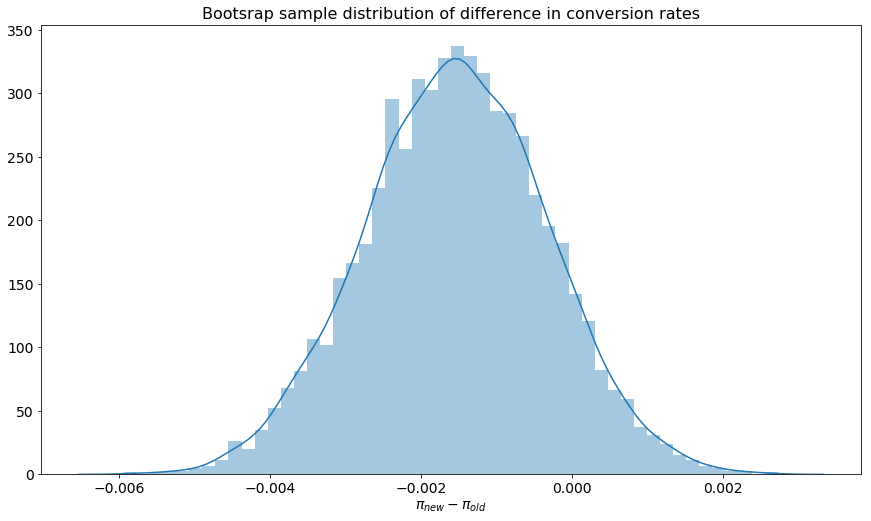

In [21]:
vis.createPlot()
sb.distplot(diffs);
plt.title("Bootsrap sample distribution of difference in conversion rates", fontsize=16);
plt.xlabel("$\pi_{new} - \pi_{old}$");

We can simulate the sampling distributions using an alternative method which avoids the use of a computationally expensive for loop by generating binomial distrubutions using the sample means as probability of conversion.

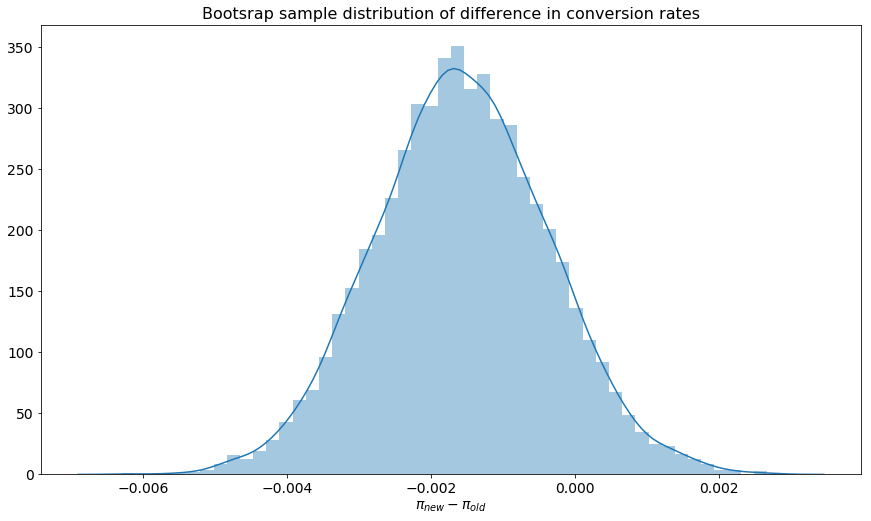

In [22]:
start = datetime.now()
p_new = np.random.binomial(df_new.shape[0], df_new.converted.mean(),10000)/df_new.shape[0]
p_old = np.random.binomial(df_old.shape[0], df_old.converted.mean(),10000)/df_old.shape[0]
p_diffs = p_new - p_old

end = datetime.now()

vis.createPlot()
sb.distplot(p_diffs);
plt.title("Bootsrap sample distribution of difference in conversion rates", fontsize=16);
plt.xlabel("$\pi_{new} - \pi_{old}$");

runtime2 = end - start

In [23]:
print("Loop runtime:", runtime)
print("Binomial runtime:", runtime2)
print("Delta:", runtime - runtime2)

Loop runtime: 0:01:20.976550
Binomial runtime: 0:00:00.003592
Delta: 0:01:20.972958


There is a huge difference in runtime speeds between the 2 methods used. The initial mehtod which made us of a for loop computes in 1 minute 20 seconds on my computer, whilst the method which uses a normalised binomial distribution computes in 3 millseconds.

We can use the standard deviation of sampling distribution `p_diffs` to generate a distribution from the null then caluclate the p-value.

std 0.0012072359677520355


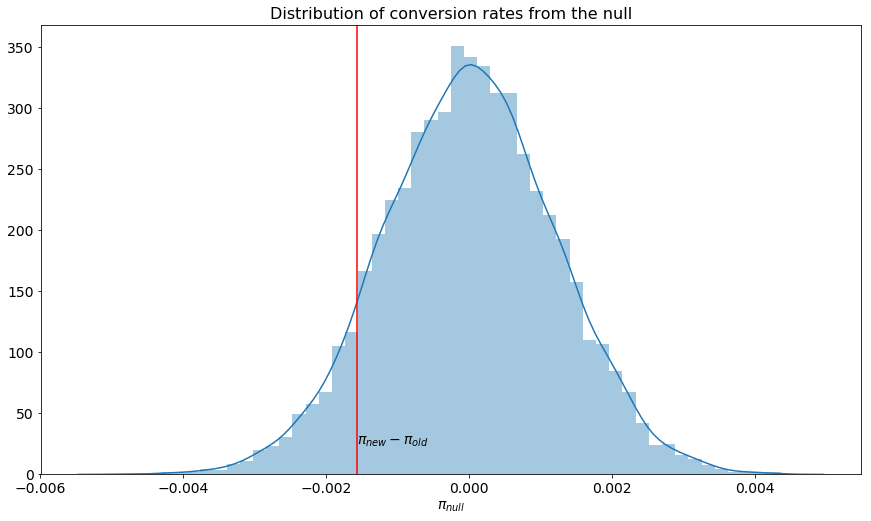

In [24]:
print("std", np.std(p_diffs))
nulls = np.random.normal(0, np.std(p_diffs), 10000)

vis.createPlot();
sb.distplot(nulls);
plt.title("Distribution of conversion rates from the null", fontsize=16);
plt.xlabel("$\pi_{null}$", fontsize=14);
plt.axvline(np.mean(p_diffs), color='r');
plt.text(np.mean(p_diffs), 25, "$\pi_{new} - \pi_{old}$", rotation=0, fontweight='bold', fontsize=14);

In [25]:
p_val = (nulls > np.mean(p_diffs)).mean()
print("p-value:", p_val)

p-value: 0.9099


### Interpretation
The p-value of 0.9099 tells us that the probability of observing our value for $\pi_{new}-\pi_{old}$ or one that favours the alternative more strongly is 91%, given that the null is true. Specifically: $$ P(\pi_{diff}\geq-0.15|H_0=True) = 0.91$$

Given a target tolerance for type I error rate of: $\alpha \leq 5\%$, we fail to reject the null hypothesis. 

Viewing the problem differently, we can construct the following hypotheses:

$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} < 0$$

The null hypothesis remains centred around 0 but we have switched the alternative hypothesis. Using the same distribution of conversion rates from the null hypothesis we can recalculate the p-value for the new set of hypothesese: $p = 0.0901$. This tells us that the probability of observing our for $\pi_{new}-\pi_{old}$ or one that favours the alternative more strongly is 9% given that the null is true: 
$$ P(\pi_{diff}\leq-0.15|H_0=True) = 0.09$$

We could reject the null based on a type 1 error rate of 10% but fail to reject the null on a type 1 error rate of 10%. Therefore, we can only state with 90% confidence that the new page performs **worse** than the old page in terms of user conversion rate. 

Practically, it is possible that the reduction in purchases on the new page is a result of _change aversion_ of the users. Lets view the conversion rates across the full time period of the experiment to determine if continuing the experiment for a longer period of time would be worth while.

In [54]:
# Extract day data from timestamp
df_new.timestamp = pd.to_datetime(df_new.timestamp)
df_new['day'] = df_new.timestamp.dt.day

df_old.timestamp = pd.to_datetime(df_old.timestamp)
df_old['day'] = df_old.timestamp.dt.day


/home/ding/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

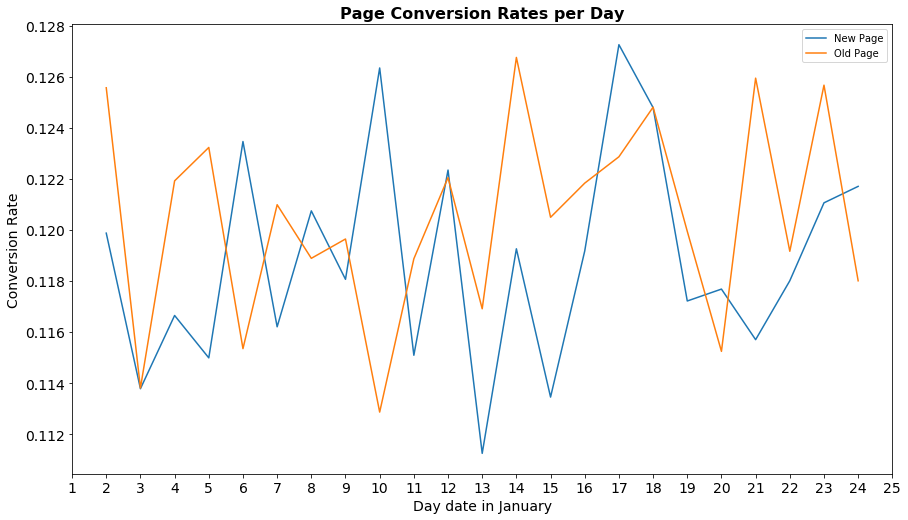

In [69]:
vis.createPlot()
sb.lineplot(data=df_new, x='day', y='converted', ci=None);
sb.lineplot(data=df_old, x='day', y='converted', ci=None);
plt.title("Page Conversion Rates per Day", fontsize=16, fontweight='bold');
plt.xlabel("Day date in January 2017");
plt.ylabel("Conversion Rate");
plt.xlim(1,25),
plt.xticks(np.arange(1,26,1));



import matplotlib.lines as mlines

l0 = mlines.Line2D([],[],linestyle='-', color=sb.color_palette()[0])
l1 = mlines.Line2D([],[],linestyle='-', color=sb.color_palette()[1])

plt.legend((l0,l1), ("New Page", "Old Page"));

There is a great deal of noise in the timeseries plot which potentially hides trends within the data. Lets compute a 5 day rolling average conversion rate for each series.

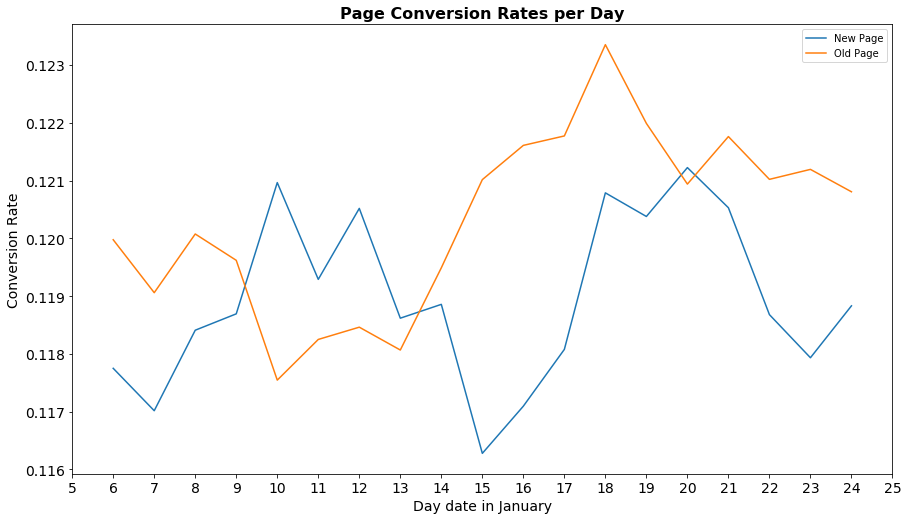

In [68]:
# Rolling Averages
series1 = df_new.groupby('day').mean().rolling(5).mean()
series2 = df_old.groupby('day').mean().rolling(5).mean()

vis.createPlot()
sb.lineplot(data=series1, x=series1.index, y='converted', ci=None);
sb.lineplot(data=series2, x=series2.index, y='converted', ci=None);

plt.title("Page Conversion Rates per Day", fontsize=16, fontweight='bold');
plt.xlabel("Day date in January 2017");
plt.ylabel("Conversion Rate");
plt.xlim(5,25);
plt.xticks(np.arange(5,26,1));


l0 = mlines.Line2D([],[],linestyle='-', color=sb.color_palette()[0])
l1 = mlines.Line2D([],[],linestyle='-', color=sb.color_palette()[1])

plt.legend((l0,l1), ("New Page", "Old Page"));

Computing the 5 day rolling average reduces the noise in the data. In general, the conversion rates for the new and old pages fluctuate around each other, with the old page performing better in the second half of the experiment timeframe. A low conversion rate for the new page in the middle stages of the experiment is likely to be bringing the overall mean conversion rate down. Even without this reduction, based on a p-value from the null of 0.9, it is unlikely that we will reject the null by gathering more data over a longer period. 

It does not appear the change aversion of the users has much of an effect, in fact, the new page may have benefited from a novelty affect early in the experiment.

## Conclusion

Based on a type 1 error rate threshold of 5%, we cannot state with statsitcal significance that the new page performs differently to the old page. We could state with 90% confidence that the new page stimulates less purchases than the old page.

There did not appear to be any trends with 


The p-value of 0.9099 tells us that the probability of observing our value for $\pi_{new}-\pi_{old}$ or one that favours the alternative more strongly is 91%, given that the null is true. Specifically: $$ P(\pi_{diff}\geq-0.15|H_0=True) = 0.91$$

Given a target tolerance for type I error rate of: $\alpha \leq 5\%$, we fail to reject the null hypothesis. Therefore, my recommendation is that the e-commerce site should **not** roll out their new web-page.


In [227]:
df_mod = pd.read_csv('../data/ab_data_clean.csv')
df_mod.timestamp = pd.to_datetime(df_mod.timestamp)

In [228]:
df_mod[['CA', 'UK','US']] = pd.get_dummies(df_mod.country)
df_mod.group=np.where(df_mod.group=='control', 0, 1)
df.head()

,user_id,timestamp,group,landing_page,converted,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,0,old_page,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,0,old_page,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,1,new_page,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,1,new_page,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,0,old_page,1,US,0,0,1


In order to use `timestamp` as a feature we'll need to group the values. Lets first look at the range.

In [229]:
print(df_mod.timestamp.max())
print(df_mod.timestamp.min())

2017-01-24 13:41:54.460509
2017-01-02 13:42:05.378582


Here we can see that the AB data was collected between 2017-01-02 and 2017-01-24. Grouping the timestamps by day will help us map out the engagement over the full course of the experiment. Grouping the timestamps by hours might also be useful for predicting conversion rates. **However**, we are missing some crucial information, we do not know what timezone this timestamp refers to, or whether the timezone is consistent throughout. We'll need to understand this information to properly validate the prediction model.

In [230]:
# extract day
df_mod['day'] = df_mod.timestamp.dt.day
# extract hour
df_mod['hour'] = df_mod.timestamp.dt.hour
# create intercept, x0
df_mod['intercept'] = 1
df_mod.head()

,user_id,timestamp,group,landing_page,converted,country,CA,UK,US,day,hour,intercept
0,851104,2017-01-21 22:11:48.556739,0,old_page,0,US,0,0,1,21,22,1
1,804228,2017-01-12 08:01:45.159739,0,old_page,0,US,0,0,1,12,8,1
2,661590,2017-01-11 16:55:06.154213,1,new_page,0,US,0,0,1,11,16,1
3,853541,2017-01-08 18:28:03.143765,1,new_page,0,US,0,0,1,8,18,1
4,864975,2017-01-21 01:52:26.210827,0,old_page,1,US,0,0,1,21,1,1


Finally lets reorder our columns, keeping only features we want to include in the model.

In [231]:
cols = ['intercept', 'group', 'CA', 'UK','US','day', 'hour','converted']
df_mod = df_mod[cols]
df_mod.head()

,intercept,group,CA,UK,US,day,hour,converted
0,1,0,0,0,1,21,22,0
1,1,0,0,0,1,12,8,0
2,1,1,0,0,1,11,16,0
3,1,1,0,0,1,8,18,0
4,1,0,0,0,1,21,1,1


Now lets split our data into a training and testing sets on a 70:30 split and convert to numpy matrices.

In [232]:
df_train = df_mod.sample(frac=0.7, replace=False, random_state=42)
idx = df_train.index
# Drop all examples which are in df_train
df_test = df_mod.drop(idx)

In [233]:
# Confirm 70:30 split of data
print(df_train.shape[0]/df_mod.shape[0], df_test.shape[0]/df_mod.shape[0])

# Confirm all data is included in df_train and df_test
assert (df_train.shape[0]+df_test.shape[0] == df_mod.shape[0])

0.7000006882691407 0.29999931173085925


In [234]:
X_train, y_train = df_train.iloc[:,:-1].values, df_train.converted.values
X_test, y_test = df_test.iloc[:,:-1].values, df_test.converted.values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((203409, 7), (203409,), (87175, 7), (87175,))

Now that our training and test data is set up as matrices we can run our model. We'll start by initialising `theta` to zero's, then assess gradient descent performance with a number of different learning rates.

In [235]:
# Initialise theta to zero
theta = np.zeros(X_train.shape[1])

In [61]:
%%time
theta_opt01, costs01 = mod.gradientDescent(X_train, theta, y_train, alpha=0.01, track=True, iters=500)

CPU times: user 33.2 s, sys: 47.7 ms, total: 33.2 s
Wall time: 8.37 s


In [62]:
%%time
theta_opt03, costs03 = mod.gradientDescent(X_train, theta, y_train, alpha=0.03, track=True, iters=500)

CPU times: user 30.3 s, sys: 0 ns, total: 30.3 s
Wall time: 7.6 s


In [122]:
%%time
theta_opt06, costs06 = mod.gradientDescent(X_train, theta, y_train, alpha=0.06, track=True, iters=500)

CPU times: user 28.3 s, sys: 0 ns, total: 28.3 s
Wall time: 7.09 s


In [63]:
%%time
theta_opt1, costs1 = mod.gradientDescent(X_train, theta, y_train, alpha=0.1, track=True, iters=500)

CPU times: user 29.6 s, sys: 23.8 ms, total: 29.6 s
Wall time: 7.4 s


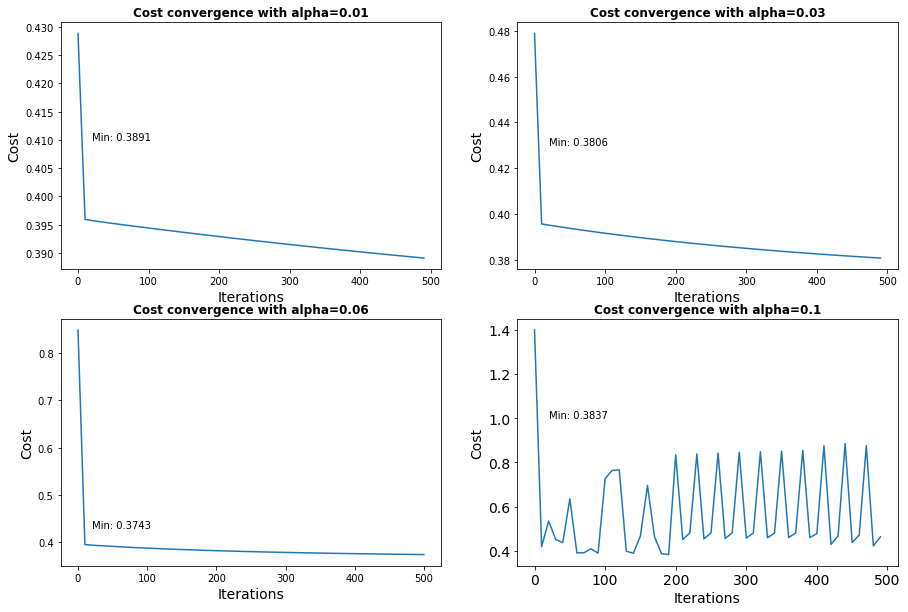

In [153]:
x01 = [i*10 for i, j in enumerate(costs01)]
y01 = [j for i, j in enumerate(costs01)]

x03 = [i*10 for i, j in enumerate(costs03)]
y03 = [j for i, j in enumerate(costs03)]

x06 = [i*10 for i, j in enumerate(costs06)]
y06 = [j for i, j in enumerate(costs06)]

x1 = [i*10 for i, j in enumerate(costs1)]
y1 = [j for i, j in enumerate(costs1)]

titles= ["Cost convergence with alpha=0.01", "Cost convergence with alpha=0.03", 
         "Cost convergence with alpha=0.06", "Cost convergence with alpha=0.1"]


axs = vis.createPlot(r=2,c=2,title=titles, figsize=[15,10], xlabel="Iterations", ylabel='Cost', sharey=False,
                    title_font=12)

plt.sca(axs[0])
sb.lineplot(x=x01,y=y01)
plt.text(20,0.41,"Min: {:.4f}".format(np.min(costs01)));

plt.sca(axs[1])
sb.lineplot(x=x03,y=y03)
plt.text(20,0.43,"Min: {:.4f}".format(np.min(costs03)));

plt.sca(axs[2])
sb.lineplot(x=x06,y=y06)
plt.text(20,0.43,"Min: {:.4f}".format(np.min(costs06)));

plt.sca(axs[3])
sb.lineplot(x=x1,y=y1)
plt.text(20,1.0,"Min: {:.4f}".format(np.min(costs1)));

### Performance
* $\alpha = 0.1$ failed to converge
* $\alpha = 0.01$, $\alpha = 0.03$ are not fully converged after 500 iterations
* $\alpha = 0.06$ appears to be almost fully converged after 500 iterations
* The computations executed in 33, 30, 28 and 29 seconds.
*** 
Lets reassess learning rate 0.03 and 0.06 using 1000 iterations

In [116]:
%%time
theta_opt03_1000, costs03_1000 = mod.gradientDescent(X_train, theta, y_train, alpha=0.03, track=True, iters=1000)

CPU times: user 55.3 s, sys: 15.9 ms, total: 55.3 s
Wall time: 13.8 s


In [154]:
%%time
theta_opt06_1000, costs06_1000 = mod.gradientDescent(X_train, theta, y_train, alpha=0.06, track=True, iters=1000)

CPU times: user 55.6 s, sys: 83.8 ms, total: 55.7 s
Wall time: 14 s


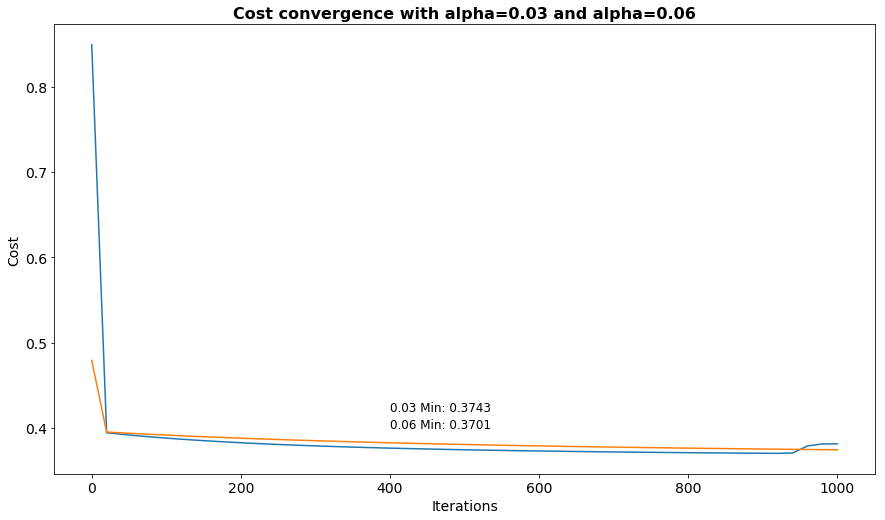

In [262]:
x03 = [i*20 for i, j in enumerate(costs03_1000)]
y03 = [j for i, j in enumerate(costs03_1000)]

x06 = [i*20 for i, j in enumerate(costs06_1000)]
y06 = [j for i, j in enumerate(costs06_1000)]

titles= ["Cost convergence with alpha=0.03 and alpha=0.06"]

axs = vis.createPlot(1,1,title=titles, xlabel="Iterations", ylabel='Cost', sharey=True)

sb.lineplot(x=x06,y=y06)
sb.lineplot(x=x03,y=y03)
plt.text(400,0.40,"0.06 Min: {:.4f}".format(np.min(costs06_1000)), fontsize=12);
plt.text(400,0.42,"0.03 Min: {:.4f}".format(np.min(costs03_1000)), fontsize=12);


### Performance
* $\alpha = 0.06$ appears to converge to a minimum of 0.3701 before **diverging**
* $\alpha = 0.03$ has a higher minimum than the $\alpha = 0.06$ and is still converging.
* The computations executed in 55.3, 55.6 seconds.
*** 
To minimise risk of divergence we'll select a learning rate $\alpha$ of 0.03. Lets inspect the convergence as we increase the number of iterations to 2000.

In [166]:
%%time
theta_opt03_2000, costs03_2000 = mod.gradientDescent(X_train, theta, y_train, alpha=0.03, track=True, iters=2000)

CPU times: user 1min 55s, sys: 51.9 ms, total: 1min 55s
Wall time: 29 s


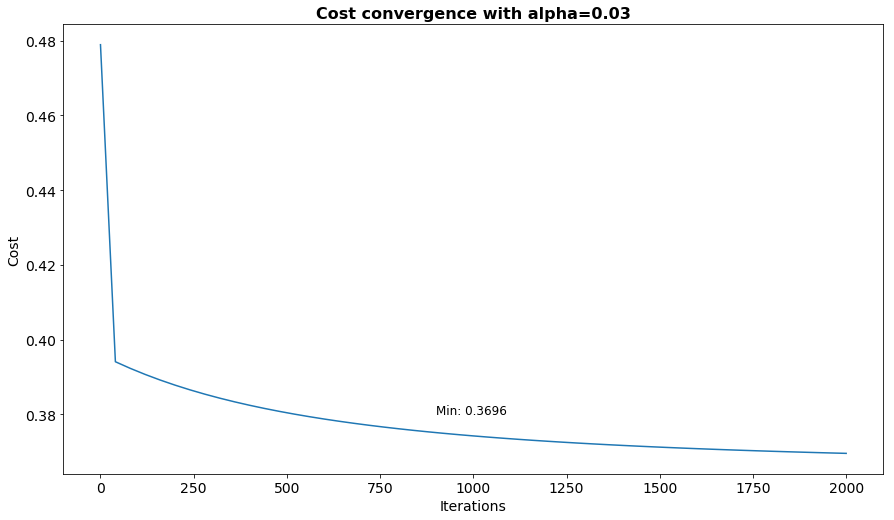

In [268]:
x03_2000 = [i*40 for i, j in enumerate(costs03_2000)]
y03_2000 = [j for i, j in enumerate(costs03_2000)]

titles= ["Cost convergence with alpha=0.03", "Cost convergence with alpha=0.06"]

axs = vis.createPlot(1,1,title=title, xlabel="Iterations", ylabel='Cost')

sb.lineplot(x=x03_2000,y=y03_2000)
plt.text(900,0.38,"Min: {:.4f}".format(np.min(costs03_2000)), fontsize=12);

### Performance
* $\alpha = 0.03$ converges to 0.3696 after 2000 iterations and 0.3806 after 500 iterations.
* The computations executed in 1 minute 55 seconds and 30 seconds respectively.
* Thess computation times should increase in speed significantly when we do not track the cost.
***
Lets now calculate our prediction accuracy, comparing performance of theta optimised with 500 and 2000 iterations.

In [246]:
# Prediction with theta optimised with 500 iterations
predict_train500 = mod.predict(X_train, theta_opt03)
predict_test500 = mod.predict(X_test, theta_opt03)

# Predictions with theta optimised with 2000 iterations
predict_train2000 = mod.predict(X_train, theta_opt03_2000)
predict_test2000 = mod.predict(X_test, theta_opt03_2000)

In [275]:
print("500 iterations ->", "train:", mod.predictAccuray(predict_train500, y_train), 
          "test:", mod.predictAccuray(predict_test500, y_test))
print("2000 iteration ->", "train:", mod.predictAccuray(predict_train2000, y_train), 
          "test:", mod.predictAccuray(predict_test2000, y_test))

500 iterations -> train: 88.02% test: 88.09%
2000 iteration -> train: 88.02% test: 88.09%


There is no difference between the prediction accuracy using theta optimised through 500 and 2000 iterations. The prediction accuracy on the test is marginally higher than our train dataset. This tells us that are model is not overfitting the data so there is no need for regularisation.

## Plan
* Add and remove features, identify significant features
* Repeat assessment using scikit learn.

In [278]:
df_test.head()

,intercept,group,CA,UK,US,day,hour,converted
2,1,1,0,0,1,11,16,0
5,1,0,0,0,1,10,15,0
7,1,0,0,0,1,17,1,0
9,1,1,1,0,0,15,18,1
13,1,1,0,0,1,22,1,0


In [287]:
X_train_day = df_train.iloc[:,:-2]
theta = np.zeros(X_train_day.shape[1])

theta_opt_day = mod.gradientDescent(X_train_day, theta, y_train, alpha=0.03, iters=500)
mod.predictAccuray(mod.predict(X_train_day,theta_opt_day), y_train)

'88.02%'

In [288]:
X = df_train.iloc[:,:-3]
theta = np.zeros(X.shape[1])

theta_opt = mod.gradientDescent(X, theta, y_train, alpha=0.03, iters=500)
mod.predictAccuray(mod.predict(X,theta_opt), y_train)

'88.02%'

In [299]:
X = df_train.iloc[:,[0,1,5,6]]
theta = np.zeros(X.shape[1])

theta_opt = mod.gradientDescent(X, theta, y_train, alpha=0.03, iters=500)
mod.predictAccuray(mod.predict(X,theta_opt), y_train)

'88.02%'

In [295]:
X = df_train.iloc[:,[0]]
theta = np.zeros(X.shape[1])

theta_opt = mod.gradientDescent(X, theta, y_train, alpha=0.03, iters=500)
mod.predictAccuray(mod.predict(X,theta_opt), y_train)

'88.02%'

In [300]:
h = mod.sigmoid(X, theta)
np.dot(X.T,(h-y_train))

array([  77337.5,   38662.5, 1009523.5,  887994. ])

In [301]:
mod.predictAccuray(mod.predict(X,theta), y_train)

'11.98%'